In [1]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders.equity_pricing_loader import USEquityPricingLoader
from zipline.pipeline.data import USEquityPricing

In [2]:
import pandas as pd

from zipline.data.bundles import register
from zipline.data.bundles.csvdir import csvdir_equities

In [3]:
from zipline.data import bundles
import os

In [4]:
os.environ['ZIPLINE_ROOT'] = r'C:\Users\leo_s\.zipline'

In [5]:
start_session = pd.Timestamp('2016-5-7', tz = 'utc')
end_session = pd.Timestamp('2019-5-7', tz = 'utc')

register(
	'cryptocompare_cryptocurrencies',
	csvdir_equities(
		['daily'], 
		'C:\\Users\\leo_s\\Documents\\Git Projects\\zipline_data', 
		), 
	calendar_name = '24/7',
	start_session = start_session,
	end_session = end_session
	)

<bound method CSVDIRBundle.ingest of <zipline.data.bundles.csvdir.CSVDIRBundle object at 0x00000262B9D23400>>

In [19]:
bundle_data = bundles.load('cryptocompare_cryptocurrencies')

In [20]:
#symbols = ['BTC', 'ETH']
#crypto_assets = []
#for ticker in symbols:
    #crypto_assets.append(bundle_data.asset_finder.lookup_symbol(ticker, end_session))

In [32]:
universe = AverageDollarVolume(window_length = 7).top(10) 
trading_calendar = get_calendar('24/7') 

In [33]:
from zipline.pipeline.factors import CustomFactor
from sklearn.linear_model import LinearRegression

class RegressionAgainstTime(CustomFactor):

    #TODO: choose a window length that spans one year's worth of trading days
    window_length = 60
    
    #TODO: use USEquityPricing's close price
    inputs = [USEquityPricing.close]
    
    #TODO: set outputs to a list of strings, which are names of the outputs
    #We're calculating regression coefficients for two independent variables, 
    # called beta and gamma
    outputs = ['beta', 'gamma']
    
    def compute(self, today, assets, out, dependent):
        
        #TODO: define an independent variable that represents time from the start to end
        # of the window length. E.g. [1,2,3...252]
        t1 = np.arange(self.window_length)
        
        #TODO: define a second independent variable that represents time ^2
        t2 = t1 ** 2
        
        # combine t1 and t2 into a 2D numpy array
        X = np.array([t1, t2]).T

    
        #TODO: the number of stocks is equal to the length of the "out" variable,
        # because the "out" variable has one element for each stock
        n_stocks = len(out)
        # loop over each asset

        for i in range(n_stocks):
            # TODO: "dependent" is a 2D numpy array that
            # has one stock series in each column,
            # and days are along the rows.
            # set y equal to all rows for column i of "dependent"
            y = dependent[:, i]
            
            # TODO: run a regression only if all values of y
            # are finite.
            if np.all(np.isfinite(y)) :
                # create a LinearRegression object
                regressor = LinearRegression()
                
                # TODO: fit the regressor on X and y
                regressor.fit(X, y)
                
                # store the beta coefficient
                out.beta[i] = regressor.coef_[0]
                
                #TODO: store the gamma coefficient
                out.gamma[i] = regressor.coef_[1]
            else:
                # store beta as not-a-number
                out.beta[i] = np.nan
                
                # TODO: store gammas not-a-number
                out.gamma[i] = np.nan


In [34]:
#Example: we'll call the RegressionAgainstTime constructor,
# pass in the "universe" variable as our mask, 
# and get the "beta" variable from that object.
# Then we'll get the rank based on the beta value.
beta_factor = (
    RegressionAgainstTime(mask=universe).beta.
    rank()
)

# TODO: similar to the beta factor,
# We'll create the gamma factor
gamma_factor = RegressionAgainstTime(mask = universe).gamma.rank()

# TODO: if we multiply the beta factor and gamma factor,
# we can then rank that product to create the conditional factor
conditional_factor = (beta_factor * gamma_factor).rank()

p = Pipeline(screen = universe)
# Add the beta, gamma and conditional factor to the pipeline
p.add(beta_factor, 'time_beta')
p.add(gamma_factor, 'time_gamma')
p.add(conditional_factor, 'conditional_factor')

In [35]:
# Very Useful Guidance on how to build the pipeline engine
import numpy as np

from zipline.assets._assets import Equity
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders import USEquityPricingLoader


EOD_BUNDLE_NAME = 'cryptocompare_cryptocurrencies'


class PricingLoader(object):
    def __init__(self, bundle_data):
        self.loader = USEquityPricingLoader(
            bundle_data.equity_daily_bar_reader,
            bundle_data.adjustment_reader)

    def get_loader(self, column):
        if column not in USEquityPricing.columns:
            raise Exception('Column not in USEquityPricing')
        return self.loader


def build_pipeline_engine(bundle_data, trading_calendar):
    pricing_loader = PricingLoader(bundle_data)

    engine = SimplePipelineEngine(
        get_loader = pricing_loader.get_loader,
        calendar = trading_calendar.all_sessions,
        asset_finder = bundle_data.asset_finder)

    return engine

In [36]:
engine = build_pipeline_engine(bundle_data, trading_calendar)

In [37]:
pipeline_data = engine.run_pipeline(p, start_session + pd.DateOffset(days = 60), end_session)

In [38]:
pipeline_data

conditional_factor  time_beta  \
2016-07-06 00:00:00+00:00 Equity(9 [BTC])                    2.0        8.0   
                          Equity(11 [DASH])                  5.0        6.0   
                          Equity(12 [DCR])                   7.0        3.0   
                          Equity(18 [ETH])                   4.0        7.0   
                          Equity(25 [LSK])                   NaN        NaN   
                          Equity(26 [LTC])                   6.0        5.0   
                          Equity(43 [WAVES])                 NaN        NaN   
                          Equity(44 [XEM])                   1.0        1.0   
                          Equity(47 [XMR])                   8.0        4.0   
                          Equity(48 [XRP])                   3.0        2.0   
2016-07-07 00:00:00+00:00 Equity(9 [BTC])                    2.0        8.0   
                          Equity(11 [DASH])                  5.0        6.0   
                          Equity(12 [DCR])                   7.0        3.0   
                          Equity(18 [ETH])                   4.0        7.0   
                          Equity(25 [LSK])                   NaN        NaN   
                          Equity(26 [LTC])                   6.0        5.0   
                          Equity(43 [WAVES])                 NaN        NaN   
                          Equity(44 [XEM])                   1.0        1.0   
                          Equity(47 [XMR])                   8.0        4.0   
                          Equity(48 [XRP])                   3.0        2.0   
2016-07-08 00:00:00+00:00 Equity(9 [BTC])                    2.0        8.0   
                          Equity(11 [DASH])                  5.0        6.0   
                          Equity(12 [DCR])                   8.0        4.0   
                          Equity(18 [ETH])                   4.0        7.0   
                          Equity(25 [LSK])                   NaN        NaN   
                          Equity(26 [LTC])                   6.0        5.0   
                          Equity(43 [WAVES])                 NaN        NaN   
                          Equity(44 [XEM])                   1.0        1.0   
                          Equity(47 [XMR])                   7.0        3.0   
                          Equity(48 [XRP])                   3.0        2.0   
...                                                          ...        ...   
2019-05-05 00:00:00+00:00 Equity(5 [BCH])                    3.0        9.0   
                          Equity(7 [BNB])                    4.0        2.0   
                          Equity(9 [BTC])                    9.0       10.0   
                          Equity(11 [DASH])                  8.0        7.0   
                          Equity(16 [EOS])                   2.0        1.0   
                          Equity(18 [ETH])                  10.0        6.0   
                          Equity(26 [LTC])                   7.0        5.0   
                          Equity(28 [MKR])                   1.0        8.0   
                          Equity(47 [XMR])                   5.0        3.0   
                          Equity(49 [ZEC])                   6.0        4.0   
2019-05-06 00:00:00+00:00 Equity(5 [BCH])                    3.0        9.0   
                          Equity(7 [BNB])                    4.0        2.0   
                          Equity(9 [BTC])                    9.0       10.0   
                          Equity(11 [DASH])                  7.0        7.0   
                          Equity(16 [EOS])                   2.0        1.0   
                          Equity(18 [ETH])                  10.0        6.0   
                          Equity(26 [LTC])                   6.0        5.0   
                          Equity(28 [MKR])                   1.0        8.0   
                          Equity(47 [XMR])                   5.0        3.0   
                 

In [39]:
from zipline.data.data_portal import DataPortal

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar = trading_calendar,
    first_trading_day = bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader = None,
    equity_daily_reader = bundle_data.equity_daily_bar_reader,
    adjustment_reader = bundle_data.adjustment_reader)

In [40]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

In [45]:
from alphalens.tears import create_full_tear_sheet
import alphalens as al

def make_factor_sheet(df, data_portal, trading_calendar, start_date, end_date):
    assets = df.index.levels[1].values.tolist()
    df = df.dropna()
    pricing = get_pricing(
        data_portal,
        trading_calendar,
        assets,
        start_date,
        end_date,
        'close'
    )
    
    factor_names = df.columns
    factor_data = {}

    for factor in factor_names:
        print("Formatting factor data for: " + factor)
        factor_data[factor] = al.utils.get_clean_factor_and_forward_returns(
            factor = df[factor],
            prices = pricing,
            periods = [7]
        )
    
    return create_full_tear_sheet(factor_data['time_gamma'])

C:\Users\leo_s\Anaconda3\envs\env_zipline\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
C:\Users\leo_s\Anaconda3\envs\env_zipline\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


Formatting factor data for: conditional_factor
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: time_beta
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: time_gamma
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,2.0,1.500000,0.500122,2058,21.142388
2,3.0,4.0,3.470407,0.499252,1943,19.960962
3,4.0,6.0,5.283487,0.579751,1732,17.793302
4,5.0,8.0,7.084920,0.741928,1943,19.960962
5,6.0,10.0,8.959670,0.890083,2058,21.142388


Returns Analysis


,7D
Ann. alpha,0.126
beta,-0.053
Mean Period Wise Return Top Quantile (bps),74.979
Mean Period Wise Return Bottom Quantile (bps),-22.032
Mean Period Wise Spread (bps),97.012


C:\Users\leo_s\Anaconda3\envs\env_zipline\lib\site-packages\pandas\core\indexes\datetimes.py:840: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


<Figure size 432x288 with 0 Axes>

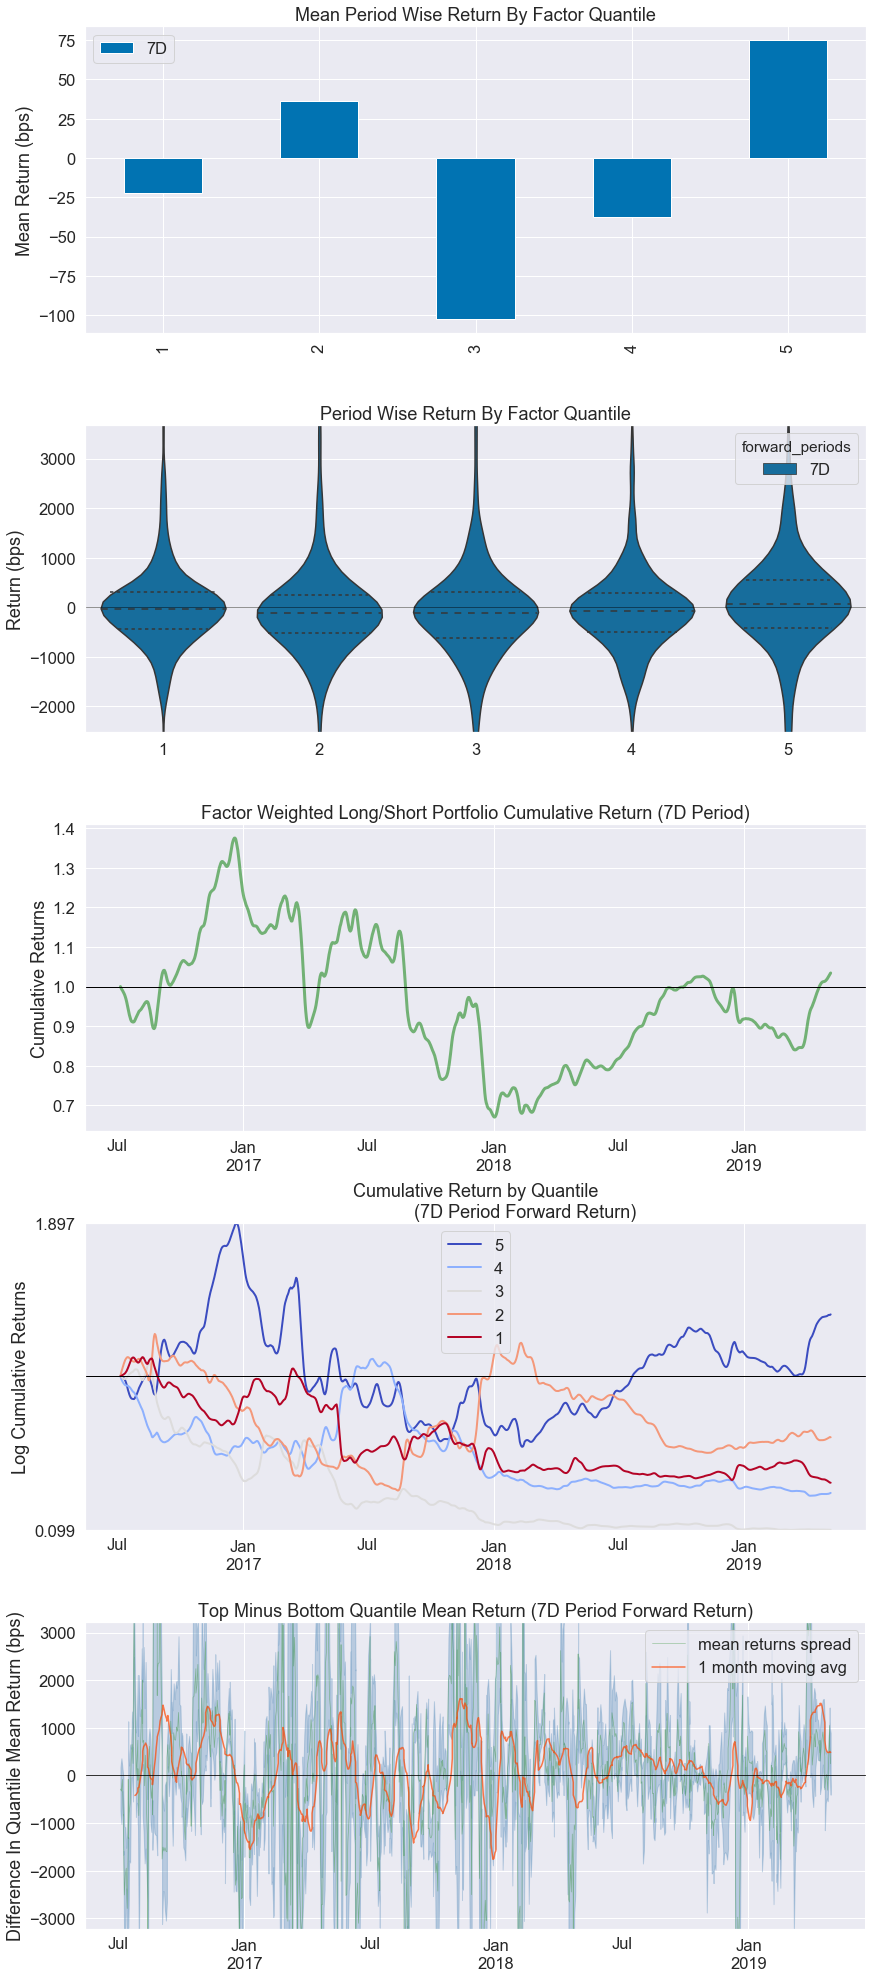

Information Analysis


,7D
IC Mean,0.030
IC Std.,0.366
Risk-Adjusted IC,0.083
t-stat(IC),2.667
p-value(IC),0.008
IC Skew,0.083
IC Kurtosis,-0.608


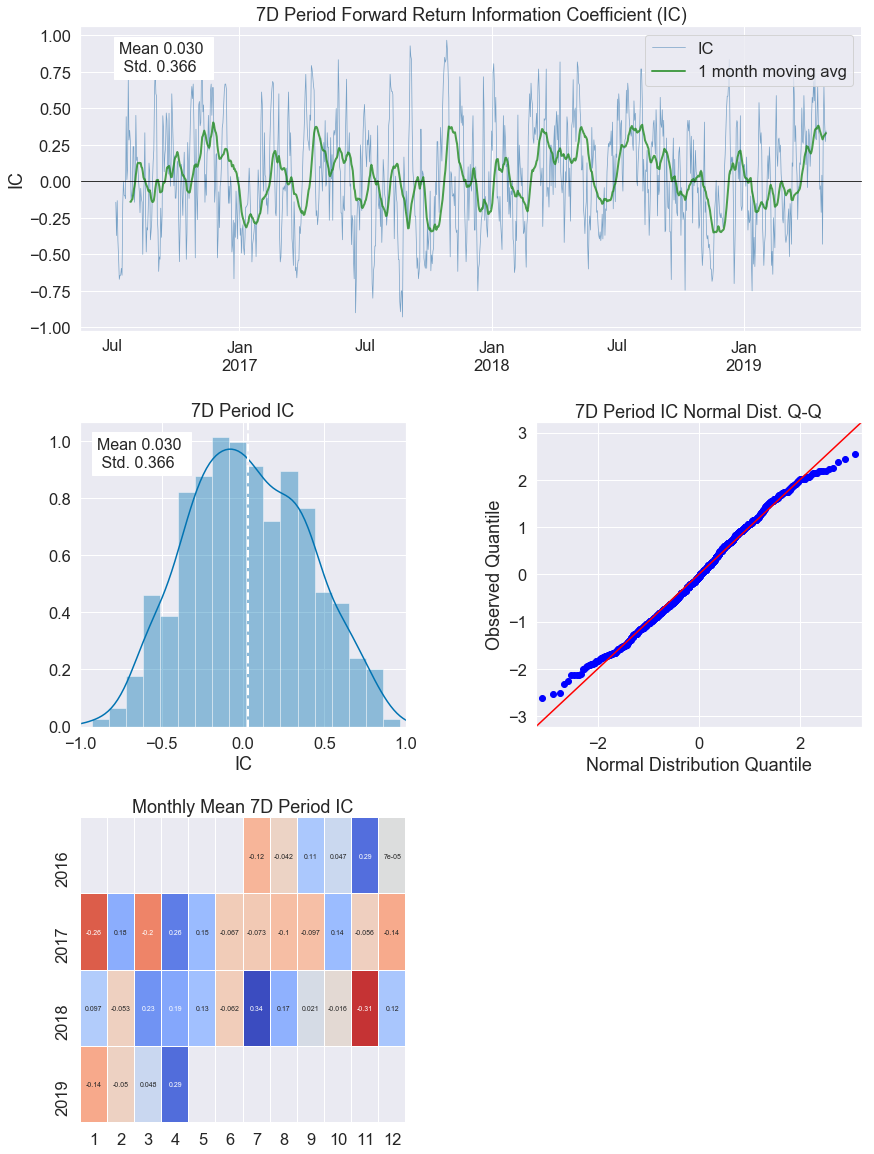

Turnover Analysis


,7D
Quantile 1 Mean Turnover,0.419
Quantile 2 Mean Turnover,0.556
Quantile 3 Mean Turnover,0.646
Quantile 4 Mean Turnover,0.540
Quantile 5 Mean Turnover,0.364


,7D
Mean Factor Rank Autocorrelation,0.629


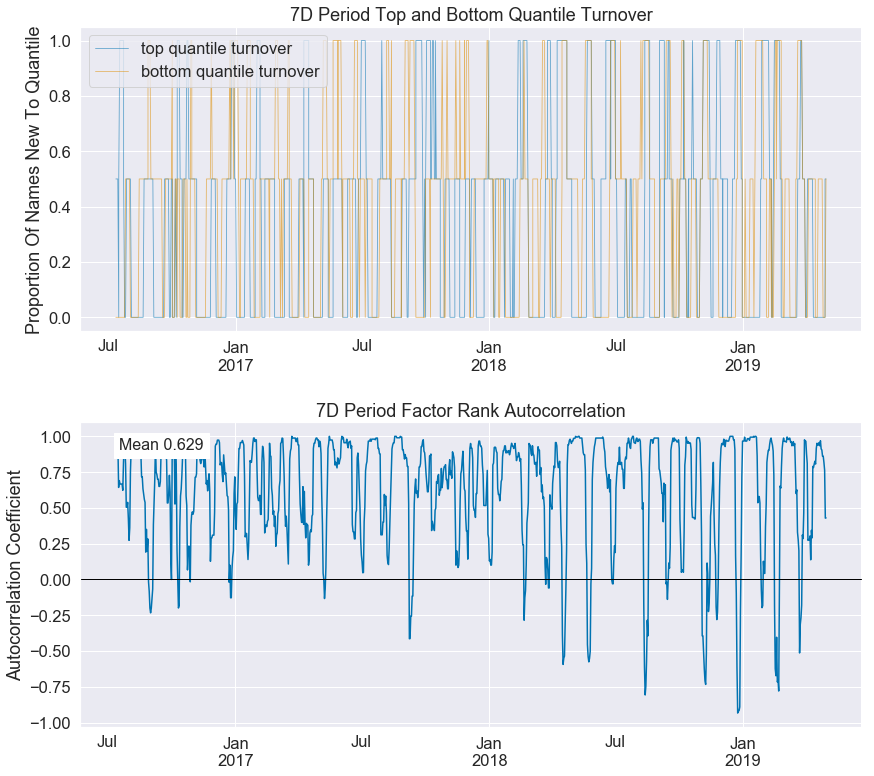

In [46]:
make_factor_sheet(pipeline_data, data_portal, trading_calendar, start_session, end_session)

In [43]:
import time
import alphalens as al

def make_factor_plot(df, data_portal, trading_calendar, start_date, end_date):
    assets = df.index.levels[1].values.tolist()
    df = df.dropna()
    pricing = get_pricing(
        data_portal,
        trading_calendar,
        assets,
        start_date,
        end_date,
        'close'
    )
    
    factor_names = df.columns
    factor_data = {}

    start_time = time.clock()
    for factor in factor_names:
        print("Formatting factor data for: " + factor)
        factor_data[factor] = al.utils.get_clean_factor_and_forward_returns(
            factor = df[factor],
            prices = pricing,
            periods = [1]
        )
    end_time = time.clock()
    print("Time to get arrange factor data: %.2f secs" % (end_time - start_time))
    
    ls_factor_returns = []

    start_time = time.clock()
    for i, factor in enumerate(factor_names):
        ls = al.performance.factor_returns(factor_data[factor])
        ls.columns = [factor]
        ls_factor_returns.append(ls)
    end_time = time.clock()
    print("Time to generate long/short returns: %.2f secs" % (end_time - start_time))

    df_ls_factor_returns = pd.concat(ls_factor_returns, axis = 1)
    (1 + df_ls_factor_returns).cumprod().plot(title = 'Factor Returns');
    return df_ls_factor_returns

C:\Users\leo_s\Anaconda3\envs\env_zipline\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
C:\Users\leo_s\Anaconda3\envs\env_zipline\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


Formatting factor data for: conditional_factor
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: time_beta
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: time_gamma
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Time to get arrange factor data: 3.17 secs
Time to generate long/short returns: 1.74 secs


,conditional_factor,time_beta,time_gamma
date,,,
2016-07-06 00:00:00+00:00,0.021096,0.040433,-0.030915
2016-07-07 00:00:00+00:00,-0.009332,-0.007833,0.007919
2016-07-08 00:00:00+00:00,-0.015057,-0.008170,-0.001498
2016-07-09 00:00:00+00:00,-0.000236,-0.000572,-0.002750
2016-07-10 00:00:00+00:00,0.006619,-0.005931,0.004651
2016-07-11 00:00:00+00:00,-0.027574,-0.018611,0.014510
2016-07-12 00:00:00+00:00,0.021991,0.019670,-0.017668
2016-07-13 00:00:00+00:00,0.029605,0.042131,-0.029263
2016-07-14 00:00:00+00:00,-0.007136,-0.024479,0.015931


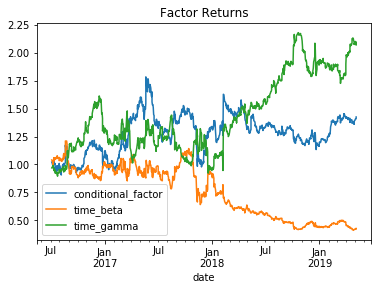

In [44]:
make_factor_plot(pipeline_data, data_portal, trading_calendar, start_session, end_session)